In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/MyDrive/Georgia Tech/Spring 2025/CS 7643/Project")
%pwd

Mounted at /content/drive


'/content/drive/MyDrive/Georgia Tech/Spring 2025/CS 7643/Project'

In [3]:
!unzip -q OCT.zip -d /content

In [4]:
%cd /content
%ls

/content
drive/  OCT/  sample_data/


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


In [6]:
data_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
train_dir = 'OCT/train'
train_dataset = datasets.ImageFolder(train_dir, data_transforms)

subset_size = 3000
indices = torch.randperm(len(train_dataset))[:subset_size]
train_dataset = Subset(train_dataset, indices)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dir = 'OCT/test'
test_dataset = datasets.ImageFolder(test_dir, data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
model = models.resnet50(pretrained=True)
fc_in_features = model.fc.in_features
model.fc = nn.Linear(fc_in_features, 4)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
epochs = 10
losses = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  losses.append(epoch_loss)

  print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

print('Done training')

Epoch 1/10 - Loss: 0.601318932118568
Epoch 2/10 - Loss: 0.397504837430538
Epoch 3/10 - Loss: 0.3247891826991071
Epoch 4/10 - Loss: 0.24749175471035725
Epoch 5/10 - Loss: 0.20135884791454103
Epoch 6/10 - Loss: 0.19141439445554576
Epoch 7/10 - Loss: 0.1809362519849488
Epoch 8/10 - Loss: 0.1554791153349141
Epoch 9/10 - Loss: 0.14629721912020383
Epoch 10/10 - Loss: 0.11015488835982978
Done training


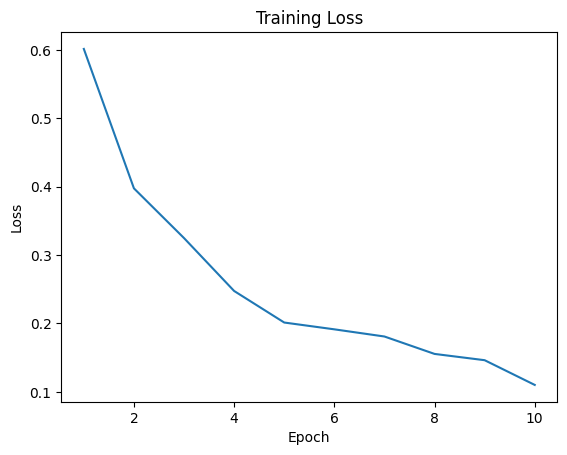

In [18]:
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [19]:
model.eval()

total = 0
total_correct = 0
all_preds = torch.tensor([]).to(device)
all_labels = torch.tensor([]).to(device)

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    n_correct = torch.sum(preds == labels)
    total_correct += n_correct
    total += len(labels)

    all_preds = torch.cat((all_preds, preds), dim=0)
    all_labels = torch.cat((all_labels, labels), dim=0)

accuracy = total_correct / total
print(f'Accuracy: {accuracy.item()}')

Accuracy: 0.9310000538825989


In [20]:
recall = torch.tensor([torch.sum((all_preds == i) & (all_labels == i)).item() / torch.sum(all_labels == i).item() for i in range(4)])
precision = torch.tensor([torch.sum((all_preds == i) & (all_labels == i)).item() / torch.sum(all_preds == i).item() for i in range(4)])
f1 = 2 * (precision * recall) / (precision + recall)
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {f1}')

Recall: tensor([0.9680, 0.9240, 0.8640, 0.9680])
Precision: tensor([0.8345, 0.9467, 0.9818, 0.9837])
F1: tensor([0.8963, 0.9352, 0.9191, 0.9758])


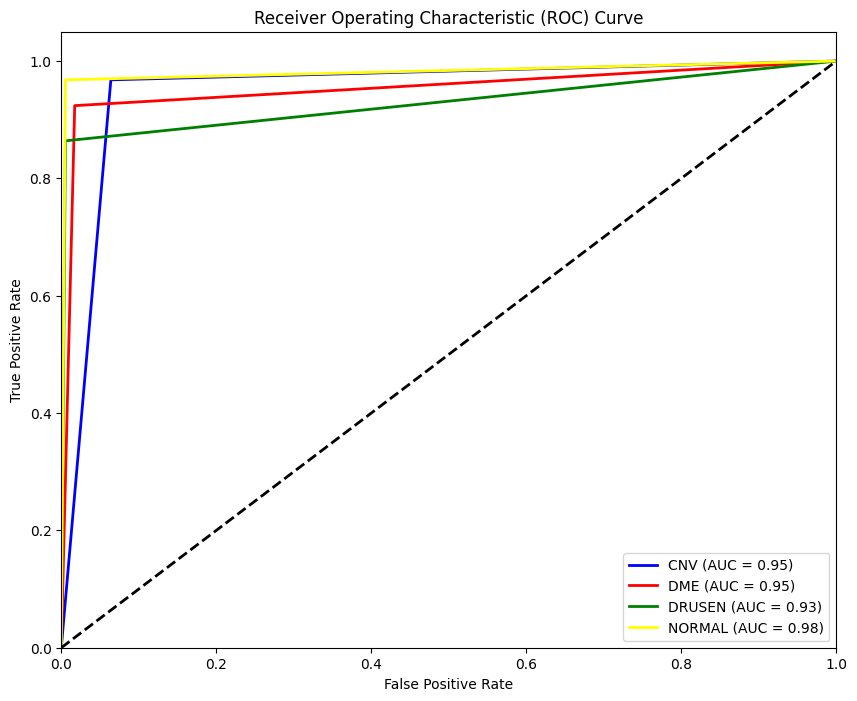

In [27]:
# AUC of ROC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# all_labels_bin = label_binarize(all_labels.cpu(), classes=[0, 1, 2, 3])
# all_preds_bin = label_binarize(all_preds.cpu(), classes=[0, 1, 2, 3])

n_classes = 4
y_test_bin = label_binarize(all_labels.cpu(), classes=range(n_classes))
y_score = label_binarize(all_preds.cpu(), classes=range(n_classes))

# Plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'yellow']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{train_dataset.dataset.classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

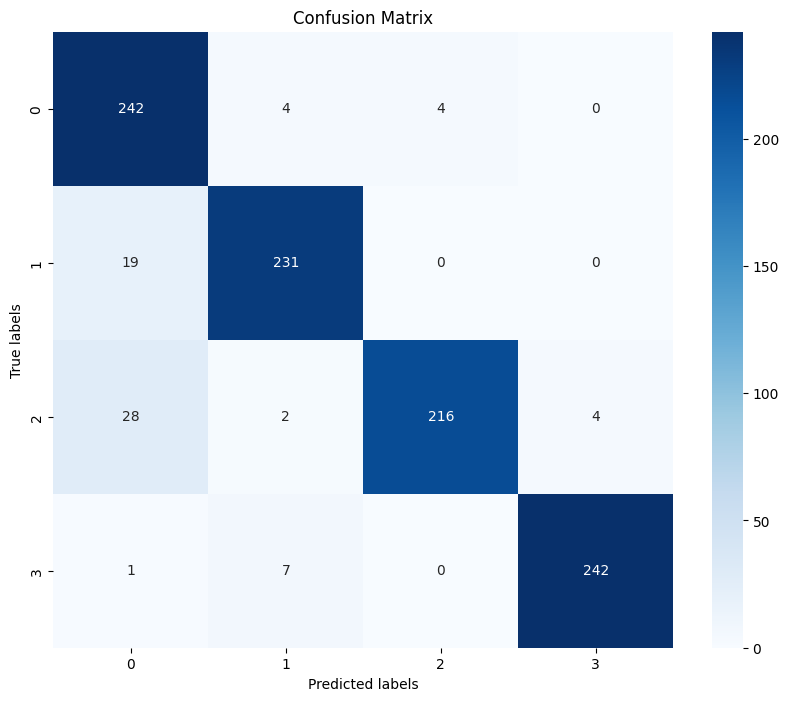

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels.cpu(), all_preds.cpu())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()